In [4]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [5]:
df = pd.read_csv("Mall_Customers.csv")

In [6]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,6,Female,45,19,42
1,7,Male,33,24,67
2,8,Female,22,60,55
3,9,Female,51,78,21
4,10,Male,29,33,79


In [18]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,100.000000,100.000000,100.000000,100.000000
mean,55.500000,39.880000,54.520000,49.460000
std,29.011492,14.520122,28.488339,24.339111
min,6.000000,18.000000,15.000000,9.000000
25%,30.750000,27.750000,27.750000,27.750000
50%,55.500000,38.000000,53.500000,50.000000
75%,80.250000,51.000000,74.500000,69.250000
max,105.000000,70.000000,120.000000,99.000000


drop any categorial column

In [9]:
df_copy = df.drop(columns=["Gender"])

In [10]:
df_copy.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
0,6,45,19,42
1,7,33,24,67
2,8,22,60,55
3,9,51,78,21
4,10,29,33,79


In [29]:
df_copy.rename(columns={'Annual Income (k$)': 'Annual Income', 'Spending Score (1-100)':'Spending Score'}, inplace=True)

Select features for clustering (X)

In [30]:
X = df_copy[["Age", "Annual Income", "Spending Score"]] # adding features

Scale features (VERY important for K-Means distance)

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
k = 3
kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)

In [33]:
labels = kmeans.fit_predict(X_scaled)

In [34]:
df_result = df_copy.copy()
df_result["Cluster"] = labels
print(df_result.head())

   CustomerID  Age  Annual Income  Spending Score  Cluster
0           6   45             19              42        2
1           7   33             24              67        1
2           8   22             60              55        0
3           9   51             78              21        2
4          10   29             33              79        1


See the centroid locations (cluster centers)

In [36]:
# cluster_centers_ are in "scaled space" because we trained on X_scaled
centers_scaled = kmeans.cluster_centers_

print("Centroids (scaled space):")
print(centers_scaled)

Centroids (scaled space):
[[-0.175748    0.92696965 -0.01054852]
 [-1.09403718 -1.20084215  1.15097688]
 [ 1.28523848 -0.28841125 -1.05559452]]


Convert centroids back to original units (so they make sense)

In [37]:
# Convert the centroids from scaled units back to original feature units
centers_original = scaler.inverse_transform(centers_scaled)

centers_df = pd.DataFrame(centers_original, columns=["Age", "Annual Income", "Spending Score"])
print("Centroids (original units):")
print(centers_df)

Centroids (original units):
         Age  Annual Income  Spending Score
0  37.340909      80.795455       49.204545
1  24.074074      20.481481       77.333333
2  58.448276      46.344828       23.896552


Plot (Income vs Spending Score)

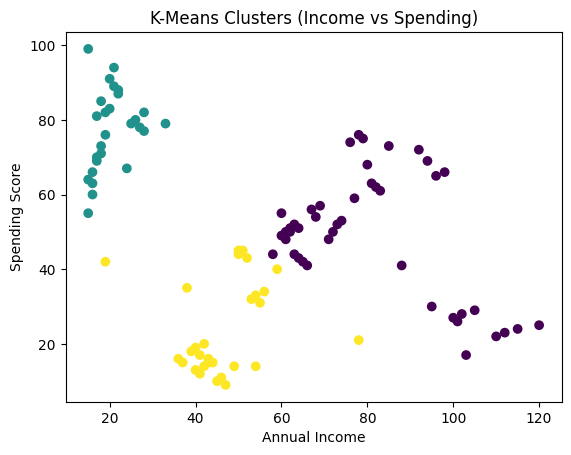

In [38]:
# Scatter plot of two features (easy to visualize)
# x-axis: income, y-axis: spending score
# c=labels colors points by their cluster number
plt.scatter(df_result["Annual Income"], df_result["Spending Score"], c=df_result["Cluster"])

plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.title("K-Means Clusters (Income vs Spending)")
plt.show()

Elbow method to find perfect clusters

[300.0, 148.92418942082998, 71.17884567549842, 47.18577174725105, 32.84769357946028, 27.75224456991099, 23.325067963683665, 19.250334214683342, 15.795065518194146, 14.28429021703251]


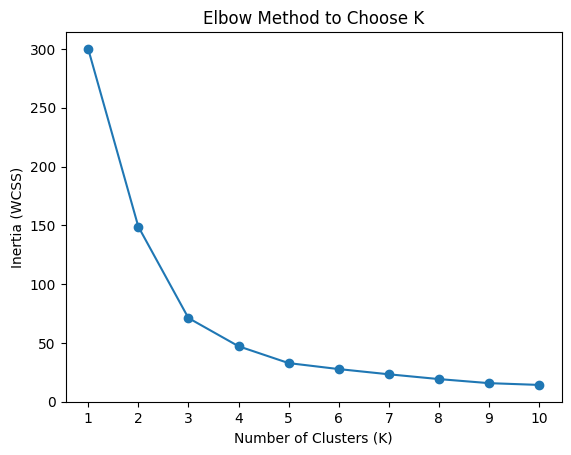

In [63]:
# 1) Pick the columns to cluster on
# -------------------------
# THEORY:
# K-Means uses distance, so we only include meaningful numeric "behavior" features.
# CustomerID is just an identifier, so we EXCLUDE it.
X = df_copy[["Age", "Annual Income", "Spending Score"]]

# -------------------------
# 2) Scale the features
# -------------------------
# THEORY:
# K-Means uses Euclidean distance. If one feature has a bigger numeric range,
# it will dominate the distance. Scaling puts features on the same scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # fit (learn mean/std) + transform (apply scaling)

# -------------------------
# 3) Run K-Means for many K values and collect inertia
# -------------------------
# THEORY:
# Inertia (WCSS) = sum of squared distances from each point to its centroid.
# As K increases, inertia always decreases, but after a point the improvement slows.
# The "elbow" point is a good K.
inertia_values = []
k_values = range(1, 11)  # try K from 1 to 10 (good for ~100 rows)

for k in k_values:
    # Create KMeans model for this K
    kmeans = KMeans(
        n_clusters=k,       # number of clusters we want to test
        init="k-means++",   # smarter centroid init to reduce bad starts
        n_init=10,          # run algorithm 10 times, keep best (lowest inertia)
        random_state=42     # reproducible results
    )

    # Fit K-Means on scaled data (K-Means training happens here)
    kmeans.fit(X_scaled)

    # Store inertia for this K
    inertia_values.append(kmeans.inertia_)
print(inertia_values)

# -------------------------
# 4) Plot the Elbow curve
# -------------------------
plt.plot(list(k_values), inertia_values, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method to Choose K")
plt.xticks(list(k_values))  # show every K on x-axis
plt.show()

K looks like 3 is the best fit as per Elbow. Final K-Means Code (after choosing K=3)

In [67]:
# Select features
X = df_copy[["Age", "Annual Income", "Spending Score"]]

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train final K-Means model
kmeans = KMeans(
    n_clusters=3,
    init="k-means++",
    n_init=10,
    random_state=42
)

# Fit model and get cluster assignments
labels = kmeans.fit_predict(X_scaled)

# Add clusters to dataframe
df_copy["Cluster"] = labels

print(df_copy.head())

   CustomerID  Age  Annual Income  Spending Score  Cluster
0           6   45             19              42        2
1           7   33             24              67        1
2           8   22             60              55        0
3           9   51             78              21        2
4          10   29             33              79        1


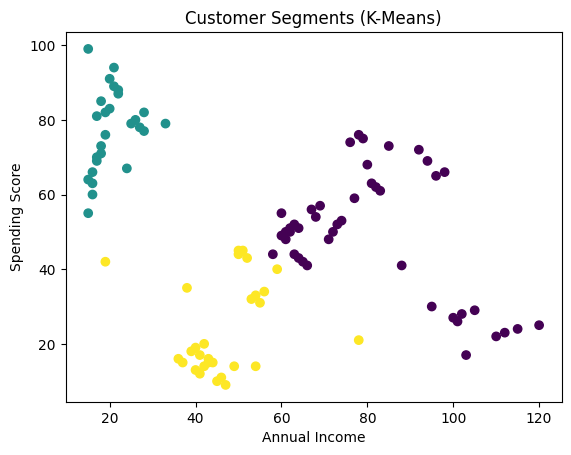

In [70]:
plt.scatter(df_copy["Annual Income"], df_copy["Spending Score"], c=df_copy["Cluster"])

plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.title("Customer Segments (K-Means)")
plt.show()